In [20]:
import diffupy
import networkx
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import scipy
from scipy import stats
import random
import numpy as np
from sklearn import neighbors
from scipy.stats import norm, gaussian_kde
from networkx import algorithms
from scipy.special import ndtr
from numpy.polynomial import Polynomial
import itertools

# temp fix for dark preview pane problem
from matplotlib import pyplot
import math

pyplot.style.use('dark_background')

## Load network and phospho data

In [21]:
network_dataframe = pd.read_csv("data/BIOGRID-PUBLICATION-13022-4.1.190.tab3.txt", sep='\t')

In [22]:
# network_dataframe.columns

In [23]:
phospho_dataframe = pd.read_csv("data/final_ascored_pep_tgr09076_09614.csv")

In [24]:
# phospho_dataframe

In [25]:
phospho_names = set(phospho_dataframe['Gene name'])
network_names = set(network_dataframe['Official Symbol Interactor A']) | set(network_dataframe['Official Symbol Interactor B']) 
common = phospho_names & network_names

print("Common gene names: {}, out of {} in phospho data and {} in network".format(len(common), len(phospho_names), 
                                                                                  len(network_names)))

Common gene names: 951, out of 1595 in phospho data and 6732 in network


In [26]:
network_dataframe = network_dataframe[['Official Symbol Interactor A', 'Official Symbol Interactor B']]

In [13]:
ppi = networkx.from_pandas_edgelist(network_dataframe, 'Official Symbol Interactor A',  
                                    'Official Symbol Interactor B').to_undirected()

## Network and phospho data properties


67 connected components in the network.
biggest one: 0.98 of vertices
Restricting to biggest component


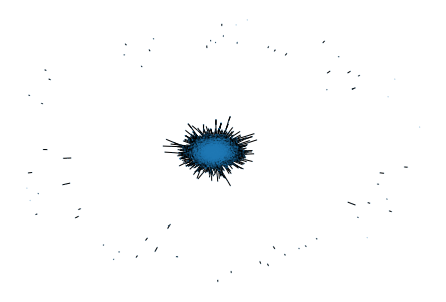

In [28]:
d = dict(ppi.degree)
networkx.draw(ppi, nodelist=d.keys(),
              node_size=[v * 0.01 for v in d.values()])

components = list(networkx.connected_components(ppi))
print(("{} connected components in the network.\nbiggest one: " +
      "{:.2f} of vertices").format(len(components),
        len(components[0]) / float(len(ppi.nodes))))

print("Restricting to biggest component")
ppi = ppi.subgraph(components[0]).copy()
common = {u for u in common if ppi.has_node(u)}

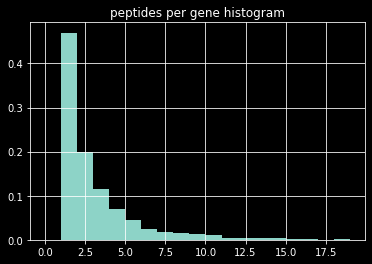

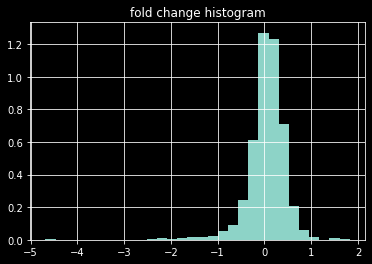

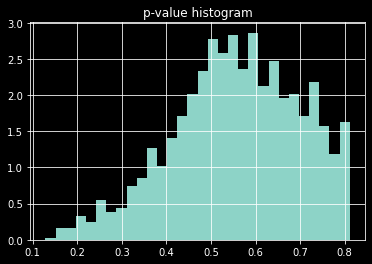

In [29]:
phospho_measure = 'log2 fold change' # 'log2 fold change'
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measure].mean()

phospho_dataframe.groupby('Gene name')[phospho_measure].count().hist(bins=range(20), density=True)
plt.title("peptides per gene histogram")
plt.show()

phospho_dataframe.groupby('Gene name')['log2 fold change'].mean().hist(density=True, bins=30)
plt.title("fold change histogram")
plt.show()

phospho_dataframe.groupby('Gene name')['1-prob'].mean().hist(density=True, bins=30)
plt.title("p-value histogram")
plt.show()

In [30]:
networkx.set_node_attributes(ppi, dict(phospho_measure_values), phospho_measure)

## Test centrality v.s. fold change

In [31]:
# closeness_centrality = networkx.closeness_centrality(ppi)
closeness_centrality = {u: networkx.closeness_centrality(ppi, u)
                        for u in common}
betweenness_centrality = networkx.betweenness_centrality(ppi)
degree_centrality = networkx.degree_centrality(ppi)

In [32]:
print("Closeness v.s. betweeness centrality")
x, y = zip(*[(closeness_centrality[gene_name], betweenness_centrality[gene_name]) for gene_name in common])
print(scipy.stats.spearmanr(x, y, nan_policy='omit'))

print("Closeness v.s. degree centrality")
x, y = zip(*[(closeness_centrality[gene_name], degree_centrality[gene_name]) for gene_name in common])
print(scipy.stats.spearmanr(x, y, nan_policy='omit'))

print("Degree v.s. betweeness centrality")
x, y = zip(*[(degree_centrality[gene_name], betweenness_centrality[gene_name]) for gene_name in common])
print(scipy.stats.spearmanr(x, y, nan_policy='omit'))


Closeness v.s. betweeness centrality
SpearmanrResult(correlation=0.8228733731653289, pvalue=1.6708651115605153e-231)
Closeness v.s. degree centrality
SpearmanrResult(correlation=0.867897000531536, pvalue=4.6351850549306e-286)
Degree v.s. betweeness centrality
SpearmanrResult(correlation=0.9505729155175738, pvalue=0.0)


In [33]:
phospho_measure = 'log2 fold change' # 'log2 fold change'
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measure].mean()

In [34]:
# Spearman correlation
print("fold change v.s. closeness")
centrality_measure = closeness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

fold change v.s. closeness


SpearmanrResult(correlation=0.009361880117107414, pvalue=0.7748459641091879)

In [35]:
# Spearman correlation
print("fold change v.s. betweeness")
centrality_measure = betweenness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

fold change v.s. betweeness


SpearmanrResult(correlation=-0.034776560611089545, pvalue=0.2878463936598121)

In [36]:
# Spearman correlation
print("fold change v.s. degree")
centrality_measure = degree_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

fold change v.s. degree


SpearmanrResult(correlation=-0.0026044946131159627, pvalue=0.9365745877402011)

In [37]:
phospho_measure = 'Non-outlier concentration' # 'log2 fold change'
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measure].mean()

In [38]:
# Spearman correlation
print("Concentration v.s. closeness")
centrality_measure = closeness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

Concentration v.s. closeness


SpearmanrResult(correlation=0.022833162081066543, pvalue=0.5130300457470531)

In [39]:
# Spearman correlation
print("Concentration v.s. betweenness")
centrality_measure = betweenness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

Concentration v.s. betweenness


SpearmanrResult(correlation=0.06810497016921126, pvalue=0.05080866183702681)

In [40]:
# Spearman correlation
print("Concentration v.s. centrality")
centrality_measure = degree_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

Concentration v.s. centrality


SpearmanrResult(correlation=0.049234667214478285, pvalue=0.15819977572896318)

## Up/Down analysis

In [41]:
phospho_measures = ['log2 fold change', '1-prob']
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measures].mean()
phospho_measure_values.columns = ['fold', 'prob']

In [42]:
def get_up_down_sets(data, fold_threshold, p_threshold):
    up_proteins = data.loc[(abs(data['fold']) > fold_threshold) &
                       (data['prob'] < p_threshold)]
    down_proteins = data.loc[(data['fold'] < -fold_threshold) &
                       (data['prob'] < p_threshold)]
    print("overactivated proteins: {}, underactivated proteins: {}, rest: {}".format(len(up_proteins),
        len(down_proteins), len(data) - len(up_proteins) - len(down_proteins)))
    return up_proteins, down_proteins

### Individual node scores

In [43]:
def metric_prot_scores(metric, proteins):
    return [metric[p] for p in proteins if p in metric]

def up_down_centrality_analysis(up_proteins, down_proteins, metric, metric_name):
    up_metric = metric_prot_scores(metric, up_proteins.index)
    down_metric = metric_prot_scores(metric, down_proteins.index)
    total_metric = metric_prot_scores(metric, phospho_measure_values.index)
    print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric),
                                                                          np.mean(down_metric),
                                                                          np.mean(total_metric)))
    print("p-values for metric {} (against full set): up: {:.2e}, down: {:.2e}".format(metric_name,
        stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

    print("")


print("2-fold, p < 0.05")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, fold_threshold=2, p_threshold=0.05)
up_down_centrality_analysis(up_proteins, down_proteins, closeness_centrality, "closeness")
up_down_centrality_analysis(up_proteins, down_proteins, betweenness_centrality, "betweenness")
up_down_centrality_analysis(up_proteins, down_proteins, degree_centrality, "degree")

print("1-fold, p < 0.2")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, fold_threshold=1, p_threshold=0.2)
up_down_centrality_analysis(up_proteins, down_proteins, closeness_centrality, "closeness")
up_down_centrality_analysis(up_proteins, down_proteins, betweenness_centrality, "betweenness")
up_down_centrality_analysis(up_proteins, down_proteins, degree_centrality, "degree")

print("0.5-fold, p < 0.3")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, fold_threshold=0.5, p_threshold=0.3)
up_down_centrality_analysis(up_proteins, down_proteins, closeness_centrality, "closeness")
up_down_centrality_analysis(up_proteins, down_proteins, betweenness_centrality, "betweenness")
up_down_centrality_analysis(up_proteins, down_proteins, degree_centrality, "degree")


print("0.0-fold, p < 0.3")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, fold_threshold=0.0, p_threshold=0.3)
up_down_centrality_analysis(up_proteins, down_proteins, closeness_centrality, "closeness")
up_down_centrality_analysis(up_proteins, down_proteins, betweenness_centrality, "betweenness")
up_down_centrality_analysis(up_proteins, down_proteins, degree_centrality, "degree")


print("0.5-fold, p < 1")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, fold_threshold=0.5, p_threshold=1)
up_down_centrality_analysis(up_proteins, down_proteins, closeness_centrality, "closeness")
up_down_centrality_analysis(up_proteins, down_proteins, betweenness_centrality, "betweenness")
up_down_centrality_analysis(up_proteins, down_proteins, degree_centrality, "degree")

2-fold, p < 0.05
overactivated proteins: 0, underactivated proteins: 0, rest: 1595
metric means: up: nan, down: nan, total: 2.33e-01
p-values for metric closeness (against full set): up: 0.00e+00, down: 0.00e+00

metric means: up: nan, down: nan, total: 6.18e-04
p-values for metric betweenness (against full set): up: 0.00e+00, down: 0.00e+00

metric means: up: nan, down: nan, total: 1.04e-03
p-values for metric degree (against full set): up: 0.00e+00, down: 0.00e+00

1-fold, p < 0.2
overactivated proteins: 12, underactivated proteins: 0, rest: 1583
metric means: up: 2.57e-01, down: nan, total: 2.33e-01
p-values for metric closeness (against full set): up: 4.03e-02, down: 0.00e+00

metric means: up: 1.06e-03, down: nan, total: 6.18e-04
p-values for metric betweenness (against full set): up: 7.34e-02, down: 0.00e+00

metric means: up: 1.82e-03, down: nan, total: 1.04e-03
p-values for metric degree (against full set): up: 5.90e-02, down: 0.00e+00

0.5-fold, p < 0.3
overactivated proteins:

In [44]:
def up_down_topological_analysis(up_proteins, down_proteins, topological_metric, random_iter,
                                 metric_name):

    up_value = topological_metric(up_proteins)
    down_value = topological_metric(down_proteins)

    # print("Generating up-sized sets")
    up_control_metric_values = []
    for i in range(random_iter):
        random_selection = np.random.choice(list(ppi.nodes.keys()), len(up_proteins))
        control_value = topological_metric(random_selection)
        up_control_metric_values.append(control_value)
        # if not (i + 1) % 250:
        #     print("Checked {} random sets".format(i + 1))
    up_control_average_metric = np.mean(up_control_metric_values)

    # print("Generating down-sized sets")
    down_control_metric_values = []
    for i in range(random_iter):
        random_selection = np.random.choice(list(ppi.nodes.keys()), len(down_proteins))
        control_value = topological_metric(random_selection)
        down_control_metric_values.append(control_value)
        # if not (i + 1) % 250:
        #     print("Checked {} random sets".format(i + 1))
    down_control_average_metric = np.mean(down_control_metric_values)
    
    print("up metric v.s. expected: {:.2f}/{:.2f}\ndown metric v.s. expected: {:.2f}/{:.2f}".format(
        up_value, up_control_average_metric, down_value, down_control_average_metric))

    plt.figure(figsize=(25, 10))
    if not np.all(np.isnan(up_control_metric_values)):
        plt.subplot(1, 2, 1)
        n, bins, patches = plt.hist(up_control_metric_values, density=True)
        plt.axvline(np.mean(up_control_metric_values), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(up_value, color='r', linestyle='solid', linewidth=1)
    #     loc = np.digitize(up_value, bins)
    #     patches[np.clip(loc,  a_min=0, a_max=len(patches) - 1)].set_fc('r')
    #     if loc != np.clip(loc, a_min=0, a_max=len(patches) - 1):
    #         print("Warning: Up value outside control histogram")
        plt.title("hist for up sized sets:")

        sign = 1 if (up_value > up_control_average_metric) else -1
        frac_more_extreme = len([val for val in up_control_metric_values if sign * val > sign * up_value]
                                ) / float(len(up_control_metric_values))
        print("p-value based on empricial tail size: {:.2e}".format(frac_more_extreme))

    if not np.all(np.isnan(down_control_metric_values)):
        plt.subplot(1, 2, 2)
        n, bins, patches= plt.hist(down_control_metric_values, density=True)
        plt.axvline(np.mean(down_control_metric_values), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(down_value, color='r', linestyle='solid', linewidth=1)
    #     loc = np.digitize(down_value, bins)
    #     patches[np.clip(loc,  a_min=0, a_max=len(patches) - 1)].set_fc('r')
    #     if loc != np.clip(loc, a_min=0, a_max=len(patches) - 1):
    #         print("Warning: Down value outside control histogram")
        plt.title("hist for down sized sets")

        sign = 1 if (down_value > down_control_average_metric) else -1
        frac_more_extreme = len([val for val in down_control_metric_values if sign * val > sign * down_value]
                                ) / float(len(down_control_metric_values))
        print("p-value based on empricial tail size: {:.2e}".format(frac_more_extreme))

    plt.show()


### Internal edges count

In [45]:
phospho_measures = ['log2 fold change', '1-prob']
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measures].mean()
phospho_measure_values.columns = ['fold', 'prob']


With 1-fold, 0.2 p-value
Internal edges by k choose 2
overactivated proteins: 12, underactivated proteins: 0, rest: 1583
up metric v.s. expected: 0.00/0.01
down metric v.s. expected: nan/nan
p-value based on empricial tail size: 0.00e+00


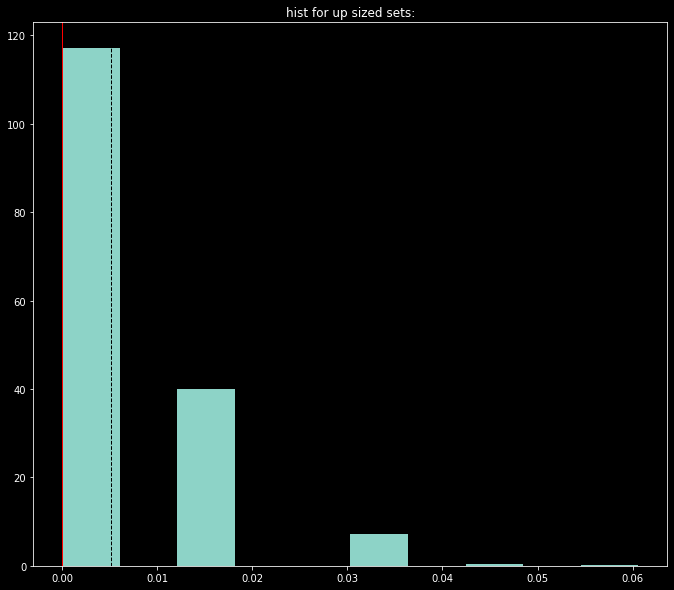

Internal edges by total edges
overactivated proteins: 12, underactivated proteins: 0, rest: 1583
up metric v.s. expected: 0.00/0.01
down metric v.s. expected: nan/nan
p-value based on empricial tail size: 0.00e+00


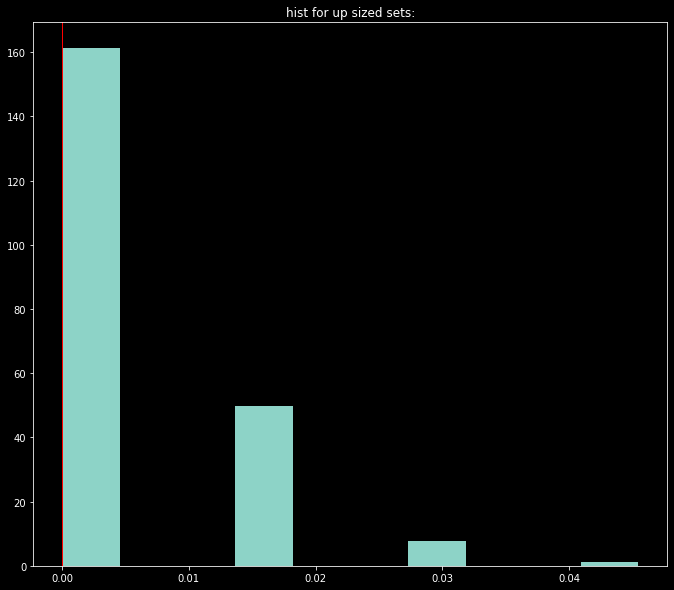

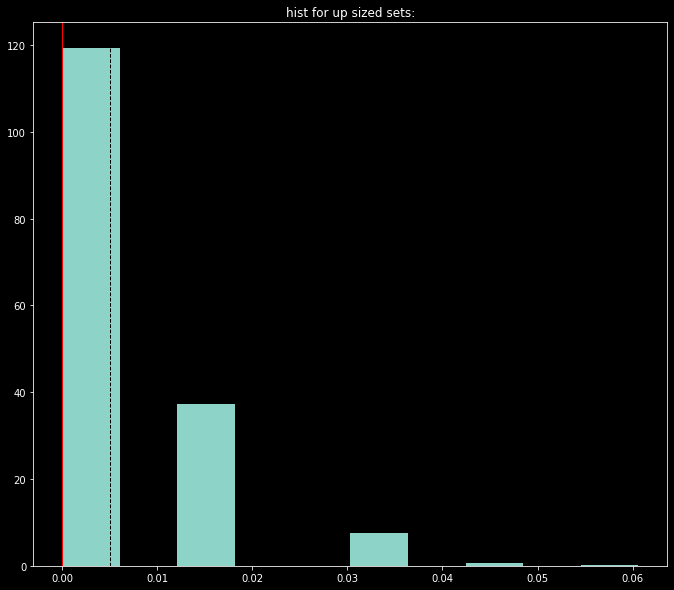

In [46]:
def normalized_internal_edges_size(vertices):
    orig_len = len(vertices)
    vertices = [v for v in vertices if ppi.has_node(v)]
    if len(vertices) == 0:
        return np.nan
    # print("Using only {} common ids out of {}".format(len(vertices), orig_len))
    internal_edges = len(ppi.subgraph(vertices).copy().edges)
    normalizer = math.comb(len(vertices), 2)
    return internal_edges / float(normalizer)

def fraction_of_internal_edges(vertices):
    orig_len = len(vertices)
    vertices = [v for v in vertices if ppi.has_node(v)]
    if len(vertices) == 0:
        return np.nan
    # print("Using only {} common ids out of {}".format(len(vertices), orig_len))
    internal_edges = len(ppi.subgraph(vertices).copy().edges)
    total_edges = len(ppi.edge_boundary(vertices)) + internal_edges
    return internal_edges / float(total_edges)

print("With 1-fold, 0.2 p-value")
print("Internal edges by k choose 2")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=1, p_threshold=0.2)
up_down_topological_analysis(up_proteins.index, down_proteins.index,
                             topological_metric=normalized_internal_edges_size, random_iter=1000,
                             metric_name='Internal_edges_by_combinatorics_by_k_2')

print("Internal edges by total edges")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=1, p_threshold=0.2)
up_down_topological_analysis(up_proteins.index, down_proteins.index,
                             topological_metric=normalized_internal_edges_size, random_iter=1000,
                             metric_name="Internal_edges_by_combinatorics_by_total_edges")

With 0.5-fold, 0.3 p-value
Internal edges by k choose 2
overactivated proteins: 63, underactivated proteins: 0, rest: 1532
up metric v.s. expected: nan/0.00
down metric v.s. expected: nan/nan
p-value based on empricial tail size: 0.00e+00


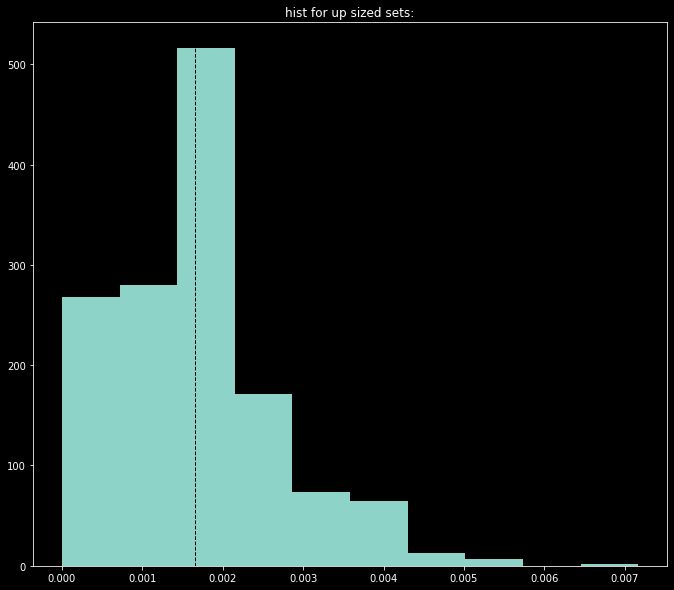

Internal edges by total edges
overactivated proteins: 63, underactivated proteins: 0, rest: 1532
up metric v.s. expected: nan/0.00
down metric v.s. expected: nan/nan
p-value based on empricial tail size: 0.00e+00


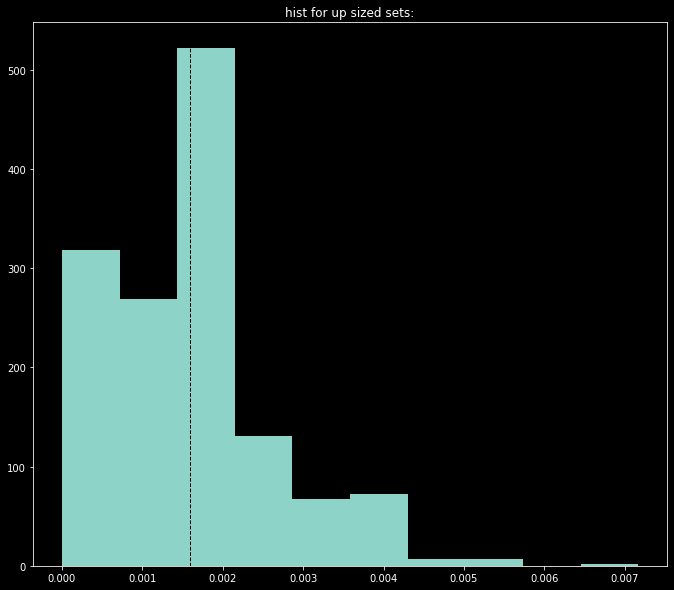

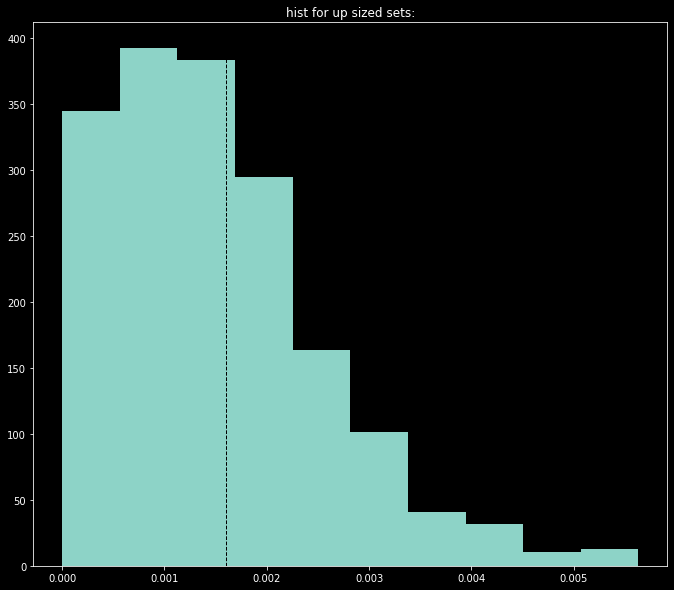

In [47]:
print("With 0.5-fold, 0.3 p-value")
print("Internal edges by k choose 2")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=0.5, p_threshold=0.3)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_internal_edges_size, random_iter=1000,
                             metric_name="Internal_edges_by_combinatorics_by_k_2")

print("Internal edges by total edges")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=0.5, p_threshold=0.3)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_internal_edges_size, random_iter=1000,
                             metric_name="Internal_edges_by_combinatorics_by_total_edges")

Path analysis

With 1-fold, 0.2 p-value
Average shortest path between nodes
overactivated proteins: 12, underactivated proteins: 0, rest: 1583
up metric v.s. expected: nan/5.42
down metric v.s. expected: nan/nan
p-value based on empricial tail size: 0.00e+00


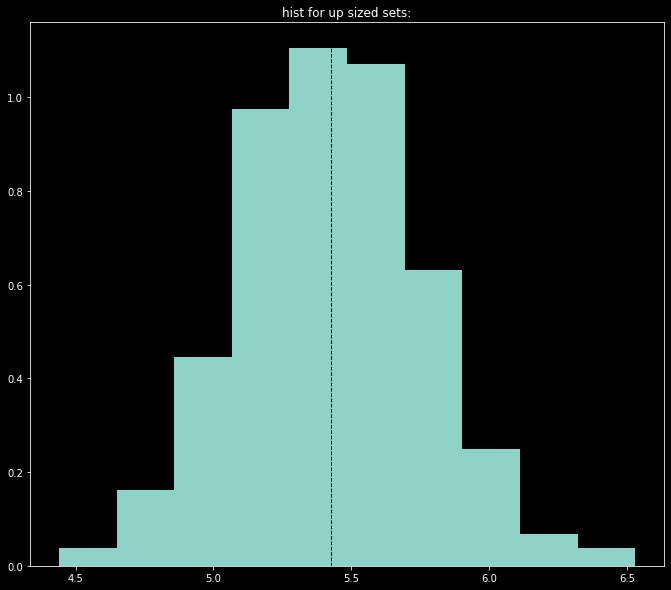

Average number of paths between nodes
overactivated proteins: 12, underactivated proteins: 0, rest: 1583


KeyboardInterrupt: 

In [50]:
def average_shortest_path(vertices):
    orig_len = len(vertices)
    vertices = [v for v in vertices if ppi.has_node(v)]
    if len(vertices) == 0:
        return np.nan
    # print("Using only {} common ids out of {}".format(len(vertices), orig_len))
    total_len = 0
    for (u, v) in itertools.combinations(vertices, 2):
        total_len += len(networkx.shortest_path(ppi, u, v))
    return total_len / float(math.comb(len(vertices), 2))

def average_num_paths(vertices):
    orig_len = len(vertices)
    vertices = [v for v in vertices if ppi.has_node(v)]
    if len(vertices) == 0:
        return np.nan
    # print("Using only {} common ids out of {}".format(len(vertices), orig_len))
    total_paths = 0
    for (u, v) in itertools.combinations(vertices, 2):
        #total_paths += len(networkx.all_simple_paths(ppi, u, v))
        total_paths += len(list(networkx.all_simple_paths(ppi, u, v)))

    return total_paths / float(math.comb(len(vertices), 2))

print("With 1-fold, 0.2 p-value")
print("Average shortest path between nodes")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=1, p_threshold=0.2)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=average_shortest_path, random_iter=1000,
                             metric_name="average_shortest_path")

print("Average number of paths between nodes")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=1, p_threshold=0.2)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=average_num_paths, random_iter=1000,
                             metric_name="average_num_paths")

With 0.5-fold, 0.3 p-value
Average shortest path between nodes
overactivated proteins: 63, underactivated proteins: 0, rest: 1532
up metric v.s. expected: nan/5.44
down metric v.s. expected: nan/nan
p-value based on empricial tail size: 0.00e+00
Average number of paths between nodes
overactivated proteins: 63, underactivated proteins: 0, rest: 1532


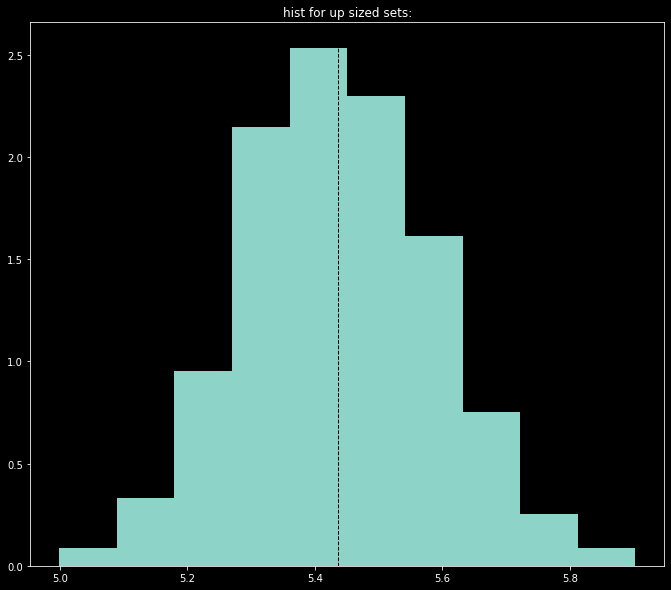

TypeError: object of type 'generator' has no len()

In [51]:
print("With 0.5-fold, 0.3 p-value")
print("Average shortest path between nodes")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=0.5, p_threshold=0.3)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=average_shortest_path, random_iter=1000,
                             metric_name="average_shortest_path")

print("Average number of paths between nodes")
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              fold_threshold=0.5, p_threshold=0.3)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=average_num_paths, random_iter=1000,
                             metric_name="average_num_paths")